In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
rep1_site = promoter[(115):(115+10)]
rep2_site = promoter[(115+20):(115+30)]

promoter = promoter.replace(rep2_site, 'G'+ rep1_site[1:])
rep2_site = 'G' + rep1_site[1:]

r1_emat = tregs.simulate.generate_emap(rep1_site, fixed=True, fixed_value=1)
r2_emat = tregs.simulate.generate_emap(rep2_site, fixed=True, fixed_value=1)

In [6]:
mutant_bank = []
for i in range(1000):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

In [7]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -14, -14
e_int = -5
n_p, n_r2 = 5000, 25

l_n_r1 = np.arange(0, 50, 2)

r1_signal_AND = []
r2_signal_AND = []

for n_r1 in l_n_r1:
    r1 = []
    r2 = []
    for i in range(1000):
        df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound,
                                [rnap_site, rep1_site, rep2_site],
                                *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat,
                                  ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                                preset_mutants=mutant_bank[i],
                                scaling_factor=10**6)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.median(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        r1.append(np.mean(footprint[(115):(115+10)]))
        r2.append(np.mean(footprint[(115+20):(115+30)]))
    r1_signal_AND.append((np.mean(r1), np.std(r1)))
    r2_signal_AND.append((np.mean(r2), np.std(r2)))

In [8]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -14, -14
e_int = -5
n_p, n_r2 = 5000, 25

l_n_r1 = np.arange(0, 50, 2)

r1_signal_OR = []
r2_signal_OR = []

for n_r1 in l_n_r1:
    r1 = []
    r2 = []
    for i in range(1000):
        df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound,
                                [rnap_site, rep1_site, rep2_site],
                                *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat,
                                  ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                                preset_mutants=mutant_bank[i],
                                scaling_factor=10**6)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.median(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        r1.append(np.mean(footprint[(115):(115+10)]))
        r2.append(np.mean(footprint[(115+20):(115+30)]))
    r1_signal_OR.append((np.mean(r1), np.std(r1)))
    r2_signal_OR.append((np.mean(r2), np.std(r2)))

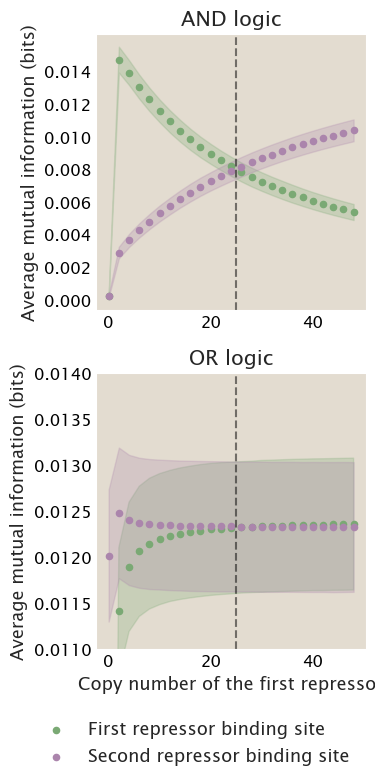

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(4,8))
ax1, ax2 = axes

ax1.fill_between(l_n_r1,
                 np.asarray(r1_signal_AND)[:, 0] - np.asarray(r1_signal_AND)[:, 1],
                 np.asarray(r1_signal_AND)[:, 0] + np.asarray(r1_signal_AND)[:, 1],
                 color='#7AA974', alpha=0.25) 
ax1.fill_between(l_n_r1,
                 np.asarray(r2_signal_AND)[:, 0] - np.asarray(r2_signal_AND)[:, 1],
                 np.asarray(r2_signal_AND)[:, 0] + np.asarray(r2_signal_AND)[:, 1],
                 color='#AB85AC', alpha=0.25) 
ax1.scatter(l_n_r1, np.asarray(r1_signal_AND)[:, 0], label='First repressor binding site', color='#7AA974', s=20)
ax1.scatter(l_n_r1, np.asarray(r2_signal_AND)[:, 0], label='Second repressor binding site', color='#AB85AC', s=20)
ax1.set_ylabel('Average mutual information (bits)', fontsize=13)
ax1.set_title('AND logic', fontsize=15)
ax1.set_yticks(np.arange(0, 0.015, 0.002))
ax1.axvline(x=25, color='black', linestyle='--', alpha=0.5)

ax2.fill_between(l_n_r1,
                 np.asarray(r1_signal_OR)[:, 0] - np.asarray(r1_signal_OR)[:, 1],
                 np.asarray(r1_signal_OR)[:, 0] + np.asarray(r1_signal_OR)[:, 1],
                 color='#7AA974', alpha=0.25)
ax2.fill_between(l_n_r1,
                 np.asarray(r2_signal_OR)[:, 0] - np.asarray(r2_signal_OR)[:, 1],
                 np.asarray(r2_signal_OR)[:, 0] + np.asarray(r2_signal_OR)[:, 1],
                 color='#AB85AC', alpha=0.25)
ax2.scatter(l_n_r1, np.asarray(r1_signal_OR)[:, 0], label='First repressor binding site', color='#7AA974', s=20)
ax2.scatter(l_n_r1, np.asarray(r2_signal_OR)[:, 0], label='Second repressor binding site', color='#AB85AC', s=20)

ax2.set_xlabel('Copy number of the first repressor', fontsize=13)
ax2.set_ylabel('Average mutual information (bits)', fontsize=13)
ax2.set_title('OR logic', fontsize=15)
ax2.set_ylim(0.011, 0.014)
ax2.legend(bbox_to_anchor=(1, -0.2), frameon=False, fontsize=13)
ax2.axvline(x=25, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../manuscript/figures/plots/fig8/knockout_doublerep.pdf', dpi=300)

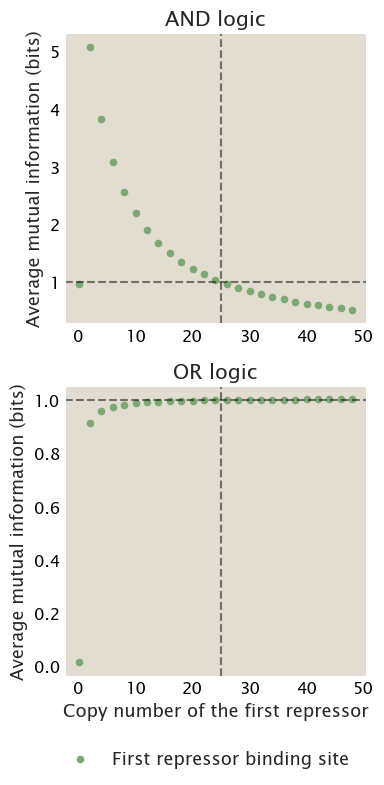

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(4,8))
ax1, ax2 = axes

ax1.scatter(l_n_r1, np.asarray(r1_signal_AND)[:, 0] / np.asarray(r2_signal_AND)[:, 0], label='First repressor binding site', color='#7AA974', s=20)
#ax1.scatter(l_n_r1, np.asarray(r2_signal_AND)[:, 0], label='Second repressor binding site', color='#AB85AC', s=20)
ax1.set_ylabel('Average mutual information (bits)', fontsize=13)
ax1.set_title('AND logic', fontsize=15)
#ax1.set_yticks(np.arange(0, 0.015, 0.002))
ax1.axhline(y=1, color='black', linestyle='--', alpha=0.5)
ax1.axvline(x=25, color='black', linestyle='--', alpha=0.5)

ax2.scatter(l_n_r1, np.asarray(r1_signal_OR)[:, 0] / np.asarray(r2_signal_OR)[:, 0], label='First repressor binding site', color='#7AA974', s=20)
#ax2.scatter(l_n_r1, np.asarray(r2_signal_OR)[:, 0], label='Second repressor binding site', color='#AB85AC', s=20)

ax2.set_xlabel('Copy number of the first repressor', fontsize=13)
ax2.set_ylabel('Average mutual information (bits)', fontsize=13)
ax2.set_title('OR logic', fontsize=15)
#ax2.set_ylim(0.011, 0.014)
ax2.legend(bbox_to_anchor=(1, -0.2), frameon=False, fontsize=13)
ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5)
ax2.axvline(x=25, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
#plt.savefig('../manuscript/figures/plots/fig8/knockout_doublerep.pdf', dpi=300)

In [ ]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -14, -14
e_int = -5
n_p, n_r2 = 5000, 25

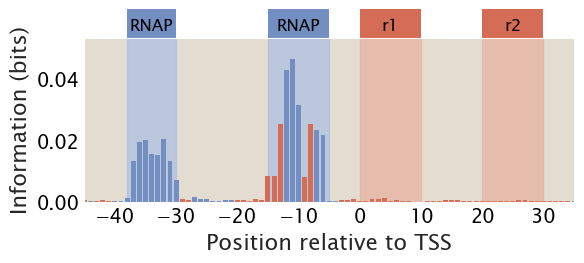

In [ ]:
n_r1 = 0

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               legend_xcoord=1.35,
                               outfile='../manuscript/figures/plots/fig7/knockout_doublerep_AND_fp1.pdf')

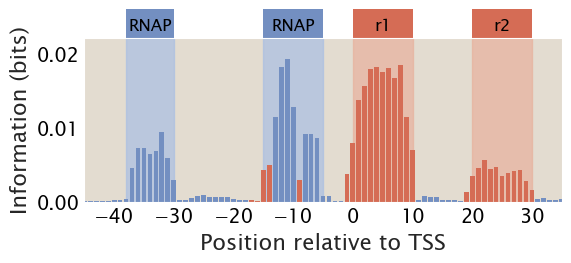

In [ ]:
n_r1 = 5

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               legend_xcoord=1.35,
                               outfile='../manuscript/figures/plots/fig7/knockout_doublerep_AND_fp2.pdf')

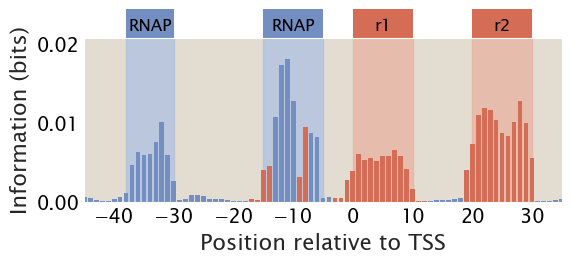

In [ ]:
n_r1 = 50

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               legend_xcoord=1.35,
                               outfile='../manuscript/figures/plots/fig7/knockout_doublerep_AND_fp3.pdf')

In [ ]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -14, -14
e_int = -5
n_p, n_r2 = 5000, 25

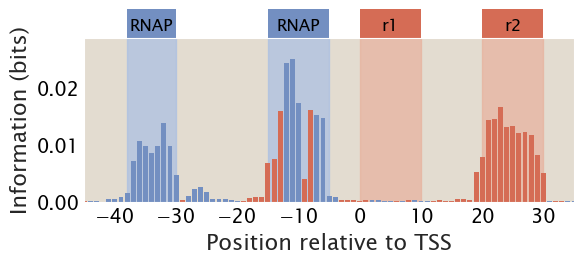

In [ ]:
n_r1 = 0

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               legend_xcoord=1.35,
                               outfile='../manuscript/figures/plots/fig7/knockout_doublerep_OR_fp1.pdf')

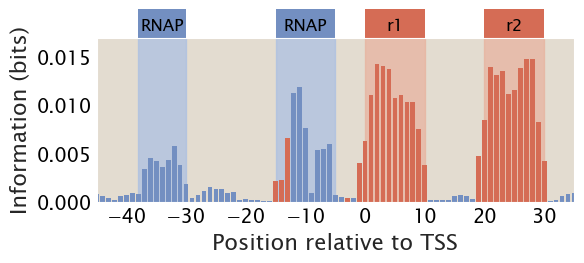

In [ ]:
n_r1 = 5

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               legend_xcoord=1.35,
                               outfile='../manuscript/figures/plots/fig7/knockout_doublerep_OR_fp2.pdf')

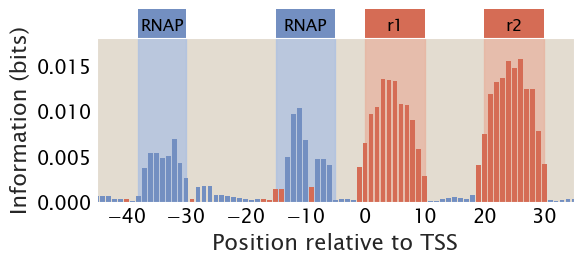

In [ ]:
n_r1 = 50

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               legend_xcoord=1.35,
                               outfile='../manuscript/figures/plots/fig7/knockout_doublerep_OR_fp3.pdf')